In [1]:
import csv
from urllib.error import HTTPError, URLError
from urllib.request import urlopen
import pickle 
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import ast # for string literal eval
from bs4 import BeautifulSoup
from nltk import tokenize

from utils import pickle_load, pickle_dump 


In [3]:
df_routes_red = pd.read_csv('data/routes-red-river-gorge-clean.csv')
df_routes_yosemite = pd.read_csv('data/routes-yosemite-valley.csv')


In [4]:
df_routes_yosemite.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
# cleaning
df_routes_yosemite.route_grade = df_routes_yosemite.route_grade.str.split(' ').str[0]
df_routes_yosemite.num_ratings = df_routes_yosemite.num_ratings.str.replace(',', '').astype(int)


In [5]:
df_routes_yosemite.route_grade.str.split('.').str[1].value_counts()

route_grade
9        30
8        28
10c      16
7        14
10a      14
10d      12
11c      12
10b      10
12a       8
11b       8
10-       6
6         6
11a       6
13a       4
5         4
10        4
10+       2
11-       2
11        2
10a/b     2
11+       2
11d       2
9+        2
8+        2
14c       2
Name: count, dtype: int64

In [6]:

# df.height = df.height.str.split(' ').str[0].astype(int)
# df.num_pitches = df.num_pitches.str.split(' ').str[0].astype(int)
# df.page_views_total = df.page_views_total.str.replace(',', '').astype(int)
# --- add difficulty as a category ---
beginners = ['4', '5', '6', '7', '8', ]
intermediate = ['9', '10']
advanced = ['11', '12', '13', '14', '15']
# make a new column that is beginner if the grade contains beginners, and so on
df_routes_yosemite['difficulty'] = np.select(
    [
        df_routes_yosemite.route_grade.str.split('.').str[1].str.contains('|'.join(beginners)),
        df_routes_yosemite.route_grade.str.split('.').str[1].str.contains('|'.join(intermediate)),
        df_routes_yosemite.route_grade.str.split('.').str[1].str.contains('|'.join(advanced))
    ],
    ['beginner', 'intermediate', 'advanced'],
    default='other'
)
# ---
# FIX NANs
df_routes_yosemite.fillna('', inplace=True)
df_routes_yosemite.difficulty.value_counts()

/tmp/ipykernel_8798/611587002.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_routes_yosemite.fillna('', inplace=True)


difficulty
intermediate    98
beginner        56
advanced        46
Name: count, dtype: int64

In [7]:
df_routes_yosemite

,route_id,route_name,route_grade,avg_rating,num_ratings,climb_data,FA,page_views_total,page_views_month,route_comments,Description,Permit Required,Location,Protection,Pitch by Pitch Description,Getting There,Be aware - Rock fall at top of Pitch 3/base of 4,Videos,difficulty
0,105997635,Oak Tree Flake,5.5,2.0,261,"Trad, 50 ft (15 m)",unknown,"8,613",43,"[{'user_id': '105999429', 'username_id': 'ty',...",Begin at a large Black Oak,,Left of Grant's Crack,Light,,,,,beginner
1,106561511,Sunnyside Bench Regular Route,5.5,2.6,431,"Trad, 400 ft (121 m), 3 pitches",unknown,"38,739",225,"[{'user_id': '106238929', 'username_id': 'engl...",One of the easiest multi-pitch climbs in the V...,,"on the left side of Sunnyside Bench, around th...",Regular rack (one #4 cam is helpful but not es...,,,,,beginner
2,105862623,The Grack - Center,5.6,3.4,859,"Trad, 500 ft (152 m), 3 pitches","Bill Sorenson, Jack Delk 1967","60,107",288,"[{'user_id': '13713', 'username_id': 'josh-hib...",On the east side of the apron a great finger c...,,The simplest approach that we found was RIGHT ...,Gear to 2 inches with a focus on small nuts an...,,,,,beginner
3,105867008,Munginella,5.6,2.9,875,"Trad, 300 ft (91 m), 3 pitches","Tom Fender, Vic Tishous, 1966.","44,125",212,"[{'user_id': '105874337', 'username_id': 'rock...",This very popular route lies in the farthest l...,,Approach: At one point you should cross the st...,"Pro to 2.5"".",,,,,beginner
4,105889783,Swan Slab Gully,5.6,2.5,494,"Trad, 310 ft (94 m), 3 pitches",unknown,"24,132",117,"[{'user_id': '105963600', 'username_id': 'chri...",Three pitches of climbing that gets better and...,,"Located in the middle of the crag, Swan Slab G...",Small to 3 inches,,,,,beginner
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,106351829,Fish Crack,5.12a,3.8,68,"Trad, 100 ft (30 m)","Henry Barber, 1975","10,577",59,"[{'user_id': '106088261', 'username_id': 'ospr...",This is the thin finger crack to the left of C...,,To the Left of Crimson Cringe,Thin to about .4 To protect the moves gettin...,,,,,advanced
196,106690707,Drive By Shooting,5.12a,3.6,125,"Sport, 70 ft (21 m)","Ken Ariza, Cade Loyd, Tucker Tech, & Chris Hol...","7,230",43,"[{'user_id': '106088261', 'username_id': 'ospr...",One of the harder .12a sport climbs in the Val...,,Park at the Chapel and walk toward the cliff. ...,Seven quickdraws. Chains on top.,,,,,advanced
197,105875268,The Phoenix,5.13a,3.9,19,"Trad, 110 ft (33 m)","Ray Jardine, May 1977","32,230",155,"[{'user_id': '105789175', 'username_id': 'kars...","""The Phoenix"" sits high on the wall, west of C...",,"From the west side of Tamarack Creek Bridge, 2...","Small to 2.25"".",,,,Tristan Bradford,advanced
198,106261545,Freerider,5.13a,3.9,68,"Trad, 3300 ft (1000 m), 30 pitches, Grade VI","Thomas and Alexander Huber, 1998","335,371","1,819","[{'user_id': '10146', 'username_id': 'george-b...",Freerider is the Astroman of the new millenniu...,,The first 10 pitches of this route are often i...,One set micronuts and nuts. One purple metoliu...,,,,,advanced


In [31]:

df_comments = pd.DataFrame()
for loc, df_routes in [('Yosemite Valley', df_routes_yosemite), ('Red River Gorge', df_routes_red)]:
    for i in range(len(df_routes)):
        df_temp = pd.DataFrame(ast.literal_eval(df_routes.route_comments[i]))
        df_temp['route_loc'] = loc
        df_temp['route_id'] = df_routes.route_id[i]
        df_temp['route_grade'] = df_routes.route_grade[i]
        df_temp['route_difficulty'] = df_routes.difficulty[i]
        df_comments = pd.concat([df_comments, df_temp], axis=0)
df_comments['date'] = df_comments.body.str.split('\n').str[-1]
df_comments.body = df_comments.body.str.split('\n').str[:-1].str.join(' ')


In [9]:
df_comments

,user_id,username_id,username,body,hometown,route_loc,route_id,route_grade,route_difficulty,date
0,105999429,ty,-Ty-,"Watch your head on the trees. Also, I found i...","Salt Lake City, UT",Yosemite Valley,105997635,5.5,beginner,"Aug 1, 2007"
1,105963600,christian-crisco-burrell,"Christian ""crisco"" Burrell",We went up to the tree when we discovered the ...,"PG, Utah",Yosemite Valley,105997635,5.5,beginner,"Oct 19, 2008"
2,106176621,floyd-hayes,Floyd Hayes,The flake is real easy but the first move or t...,,Yosemite Valley,105997635,5.5,beginner,"Aug 2, 2010"
3,106088261,osprey-overhang,Osprey Overhang,Try building an anchor from the stacked blocks...,...,Yosemite Valley,105997635,5.5,beginner,"Sep 5, 2010"
4,106967013,adam-voss,Adam Voss,Nice moves up the flake. If you don't have a #...,"Bend, OR",Yosemite Valley,105997635,5.5,beginner,"Nov 21, 2010"
...,...,...,...,...,...,...,...,...,...,...
1,dylan-randall,NaN,Dylan Randall,"Really, this climb is something incredible. Ev...","Nashville, TN",Red River Gorge,106333601,5.12d,advanced,"May 6, 2015"
2,brie-abram,NaN,Brie Abram,This route is incredible. If this grade is har...,"Celo, NC",Red River Gorge,106333601,5.12d,advanced,"Sep 18, 2017"
3,chris-smallwood,NaN,Chris Smallwood,vimeo.com/245977683,,Red River Gorge,106333601,5.12d,advanced,"Apr 20, 2018"
4,nathan-devan,NaN,Nathan Devan,youtu.be/XhJOAtUSuKU,"Huntsville, AL",Red River Gorge,106333601,5.12d,advanced,"Nov 29, 2020"


In [107]:
df_comments.to_csv('data/comments/comments.csv')

In [58]:
# df_comments.to_csv('data/comments-red-river-gorge.csv', index=False)
# df_comments = pd.read_csv('data/comments-red-river-gorge.csv')

In [108]:
from utils import word_freq_graph

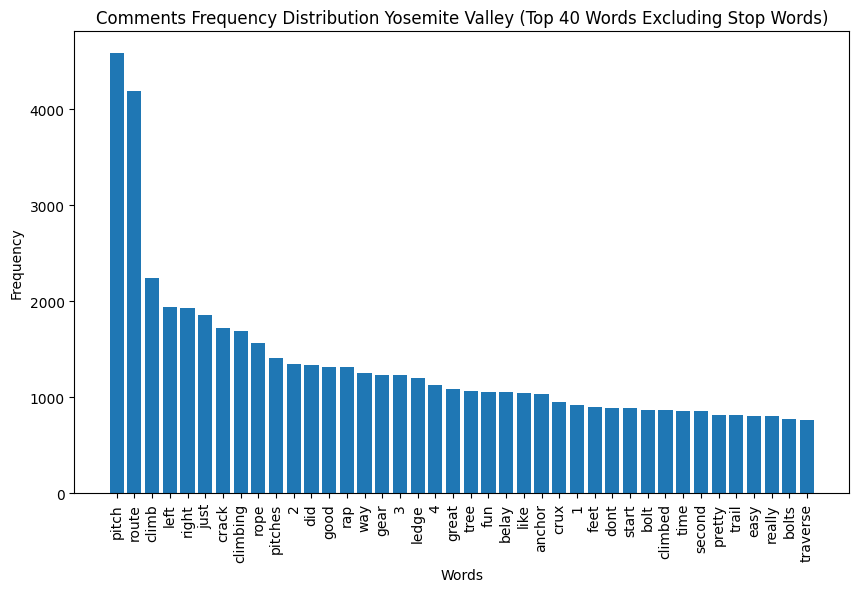

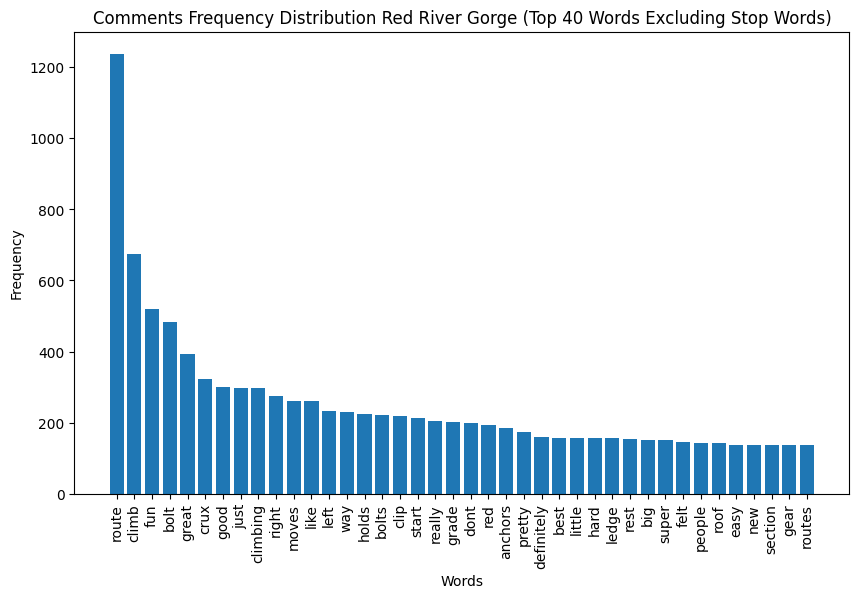

In [113]:

for loc in ['Yosemite Valley', 'Red River Gorge']:
    all_text = ' '.join(df_comments.loc[df_comments['route_loc'] == loc, 'body'].dropna())
    top_n = 40
    title = f'Comments Frequency Distribution {loc} (Top {top_n} Words Excluding Stop Words)'
    word_freq_graph(all_text, top_n, title)

In [116]:
df_comments[df_comments.route_loc == 'Yosemite Valley'].route_difficulty.value_counts()

route_difficulty
beginner    4898
Name: count, dtype: int64

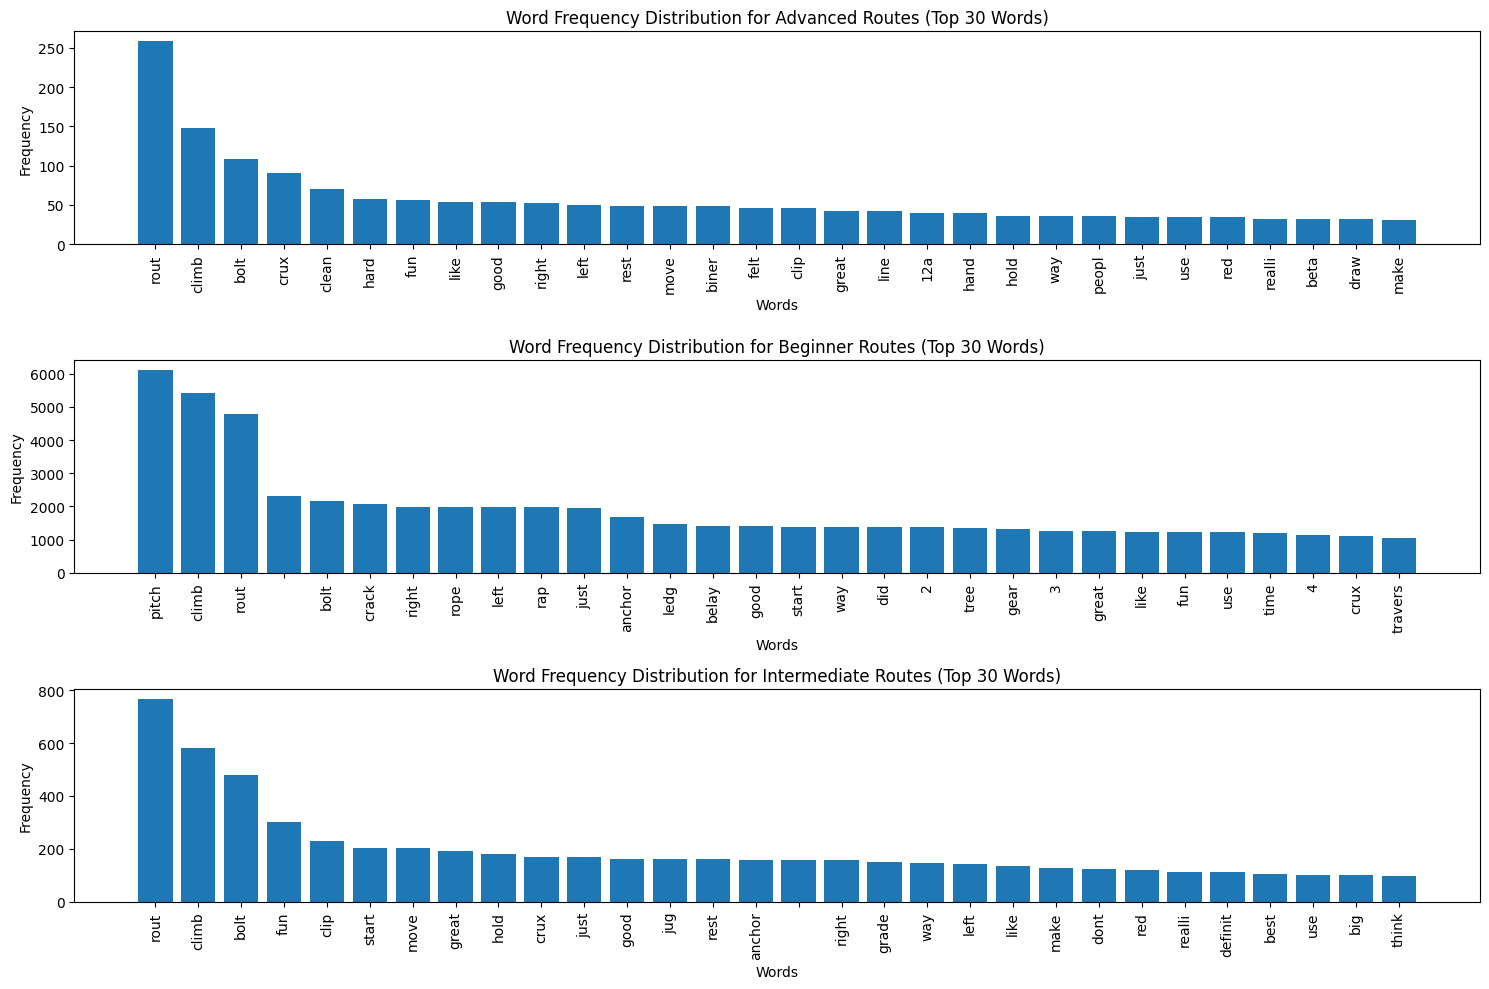

In [114]:
from nltk.stem import PorterStemmer
# Initialize the Porter Stemmer
stemmer = PorterStemmer()

# Group the DataFrame by 'route_difficulty' and concatenate the comments for each group
grouped_texts = df_comments.groupby('route_difficulty')['body'].apply(lambda x: ' '.join(x.dropna()))

# Preprocess the text for each group
grouped_processed_texts = {
    difficulty: [stemmer.stem(remove_punctuation(word).lower()) 
                 for word in text.split() 
                 if remove_punctuation(word).lower() not in ENGLISH_STOP_WORDS and word.strip()]
    for difficulty, text in grouped_texts.items()
}

# Count word frequencies for each group
grouped_word_freqs = {difficulty: Counter(words) for difficulty, words in grouped_processed_texts.items()}


# Sorting words by frequency in descending order for each group
sorted_grouped_word_freqs = {
    difficulty: dict(sorted(freqs.items(), key=lambda item: item[1], reverse=True))
    for difficulty, freqs in grouped_word_freqs.items()
}

# Plotting the graphs for each 'route_difficulty' class
plt.figure(figsize=(15, 10))
top_n = 30  # Top N words to display

for i, (difficulty, freqs) in enumerate(sorted_grouped_word_freqs.items(), start=1):
    top_words = list(freqs.keys())[:top_n]
    top_freqs = list(freqs.values())[:top_n]

    plt.subplot(len(sorted_grouped_word_freqs), 1, i)
    plt.bar(top_words, top_freqs)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.title(f'Word Frequency Distribution for {difficulty.capitalize()} Routes (Top 30 Words)')

plt.tight_layout()
plt.show()

### Sentiment Analysis EDA

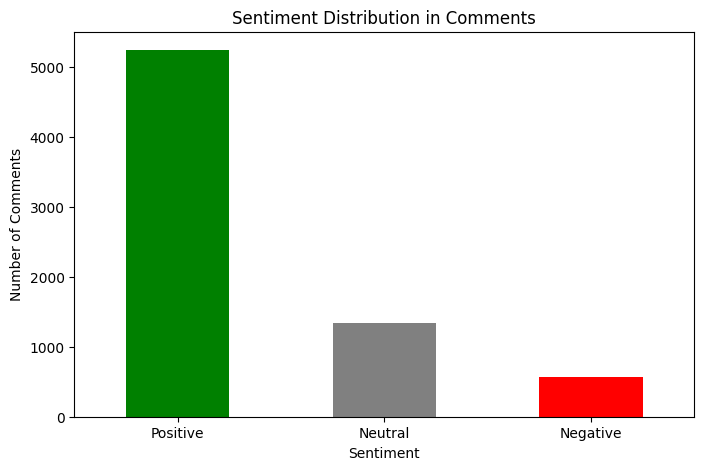

In [161]:
# Loading the newly uploaded DataFrame to perform sentiment analysis
from textblob import TextBlob

def categorize_sentiment(text):

    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0.05:
        return 'Positive'
    elif analysis.sentiment.polarity < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Applying sentiment analysis to the 'body' column
df_comments['sentiment'] = df_comments['body'].apply(lambda x: categorize_sentiment(str(x)))

# Counting the number of each sentiment category in the new dataset

# Plotting the sentiment distribution for the new dataset
plt.figure(figsize=(8, 5))
new_sentiment_counts = df_comments['sentiment'].value_counts()
new_sentiment_counts.plot(kind='bar', color=['green', 'gray', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')
plt.title('Sentiment Distribution in Comments')
plt.xticks(rotation=0)
plt.show()


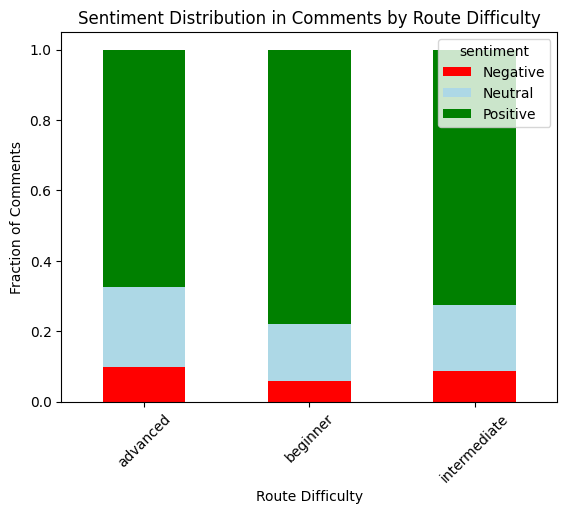

In [162]:
route_difficulty_sentiment_counts = df_comments.groupby([ 'route_difficulty', 'sentiment']).size()

# Unstacking the multi-level index to create a DataFrame suitable for plotting
route_difficulty_sentiment_counts_unstacked = route_difficulty_sentiment_counts.unstack().fillna(0)
route_difficulty_sentiment_fractions = route_difficulty_sentiment_counts_unstacked.div(route_difficulty_sentiment_counts_unstacked.sum(axis=1), axis=0)

# Plotting the sentiment distribution for each 'route_difficulty' as a stacked bar chart
route_difficulty_sentiment_fractions.plot(kind='bar', stacked=True, color=['red', 'lightblue', 'green'])
plt.xlabel('Route Difficulty')
plt.ylabel('Fraction of Comments')
plt.title('Sentiment Distribution in Comments by Route Difficulty')
plt.xticks(rotation=45)
plt.show()

In [30]:
df_comments

,user_id,username_id,username,body,hometown,route_loc,route_id,route_grade,route_difficulty,date
91,200130017,eli-delventhal,Eli Delventhal,I gotta throw some shade at Tristan Bradford –...,"San Francisco, CA",Yosemite Valley,105836362,5.7,beginner,· Lost...
29,111908446,adamsc,adamsc,I think I may have lost one of my ratty TCs di...,"Arvada, CO",Yosemite Valley,105833552,5.8+,beginner,· Lost...
91,200130017,eli-delventhal,Eli Delventhal,I gotta throw some shade at Tristan Bradford –...,"San Francisco, CA",Yosemite Valley,105836362,5.7,beginner,· Lost...
29,111908446,adamsc,adamsc,I think I may have lost one of my ratty TCs di...,"Arvada, CO",Yosemite Valley,105833552,5.8+,beginner,· Lost...
23,shane-brown,NaN,Shane Brown,Only 20%? You got a few years left! youtub...,,Red River Gorge,105889536,5.9,beginner,· Lost...
23,david-k,NaN,David K,"Quite a nice route, good for breaking into the...","The Road, Sometimes Chattan…",Red River Gorge,106065471,5.10a,intermediate,· Lost...
23,shane-brown,NaN,Shane Brown,Only 20%? You got a few years left! youtub...,,Red River Gorge,105889536,5.9,beginner,· Lost...
23,david-k,NaN,David K,"Quite a nice route, good for breaking into the...","The Road, Sometimes Chattan…",Red River Gorge,106065471,5.10a,intermediate,· Lost...


In [34]:
df_comments = df_comments[~df_comments.date.str.strip().str.contains('· Temporary Report|· Lost & Found')]
df_comments = df_comments[~df_comments.date.str.strip().str.contains('ago')]

In [36]:
df_comments.date = pd.to_datetime(df_comments.date)

,user_id,username_id,username,body,hometown,route_loc,route_id,route_grade,route_difficulty,date
0,105999429,ty,-Ty-,"Watch your head on the trees. Also, I found i...","Salt Lake City, UT",Yosemite Valley,105997635,5.5,beginner,2007-08-01
1,105963600,christian-crisco-burrell,"Christian ""crisco"" Burrell",We went up to the tree when we discovered the ...,"PG, Utah",Yosemite Valley,105997635,5.5,beginner,2008-10-19
2,106176621,floyd-hayes,Floyd Hayes,The flake is real easy but the first move or t...,,Yosemite Valley,105997635,5.5,beginner,2010-08-02
3,106088261,osprey-overhang,Osprey Overhang,Try building an anchor from the stacked blocks...,...,Yosemite Valley,105997635,5.5,beginner,2010-09-05
4,106967013,adam-voss,Adam Voss,Nice moves up the flake. If you don't have a #...,"Bend, OR",Yosemite Valley,105997635,5.5,beginner,2010-11-21
...,...,...,...,...,...,...,...,...,...,...
1,dylan-randall,NaN,Dylan Randall,"Really, this climb is something incredible. Ev...","Nashville, TN",Red River Gorge,106333601,5.12d,advanced,2015-05-06
2,brie-abram,NaN,Brie Abram,This route is incredible. If this grade is har...,"Celo, NC",Red River Gorge,106333601,5.12d,advanced,2017-09-18
3,chris-smallwood,NaN,Chris Smallwood,vimeo.com/245977683,,Red River Gorge,106333601,5.12d,advanced,2018-04-20
4,nathan-devan,NaN,Nathan Devan,youtu.be/XhJOAtUSuKU,"Huntsville, AL",Red River Gorge,106333601,5.12d,advanced,2020-11-29


In [50]:
from textblob import TextBlob
# Function to calculate sentiment polarity
def get_sentiment(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return None
# Apply sentiment analysis on the 'body' column
df_comments['sentiment'] = df_comments['body'].apply(get_sentiment)

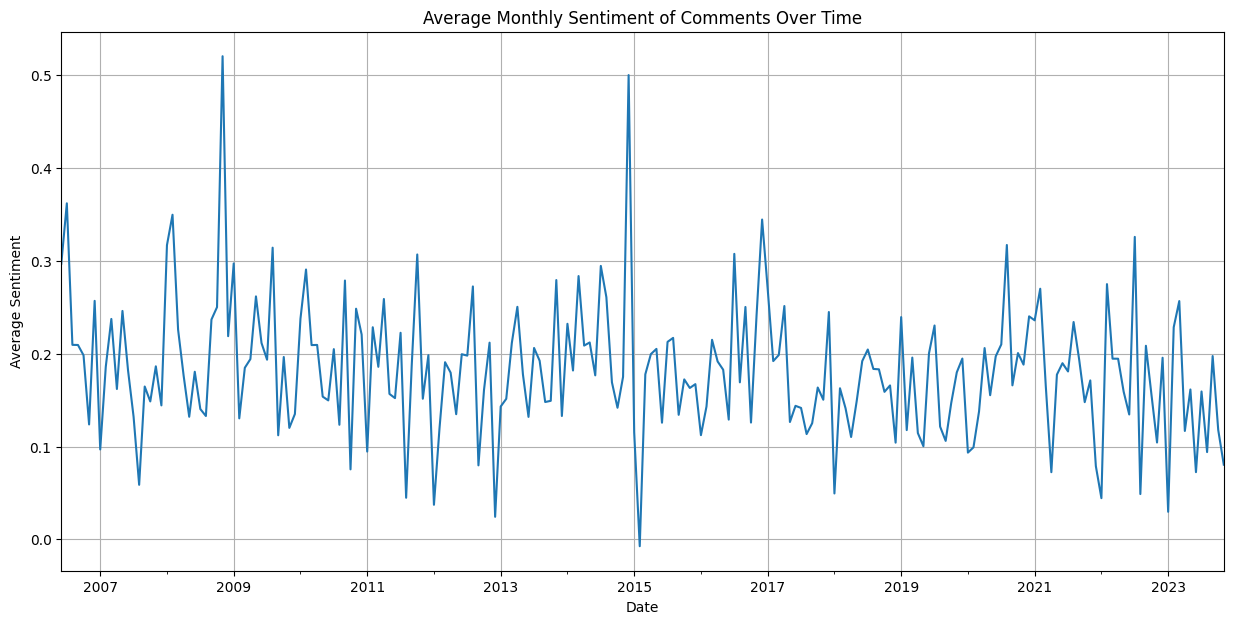

In [66]:
# Resample to get monthly average sentiment
monthly_sentiment = df_comments.resample('M', on='date')['sentiment'].mean()

# Plotting the sentiment over time
plt.figure(figsize=(15, 7))
monthly_sentiment.plot(title='Average Monthly Sentiment of Comments Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.grid(True)
plt.show()

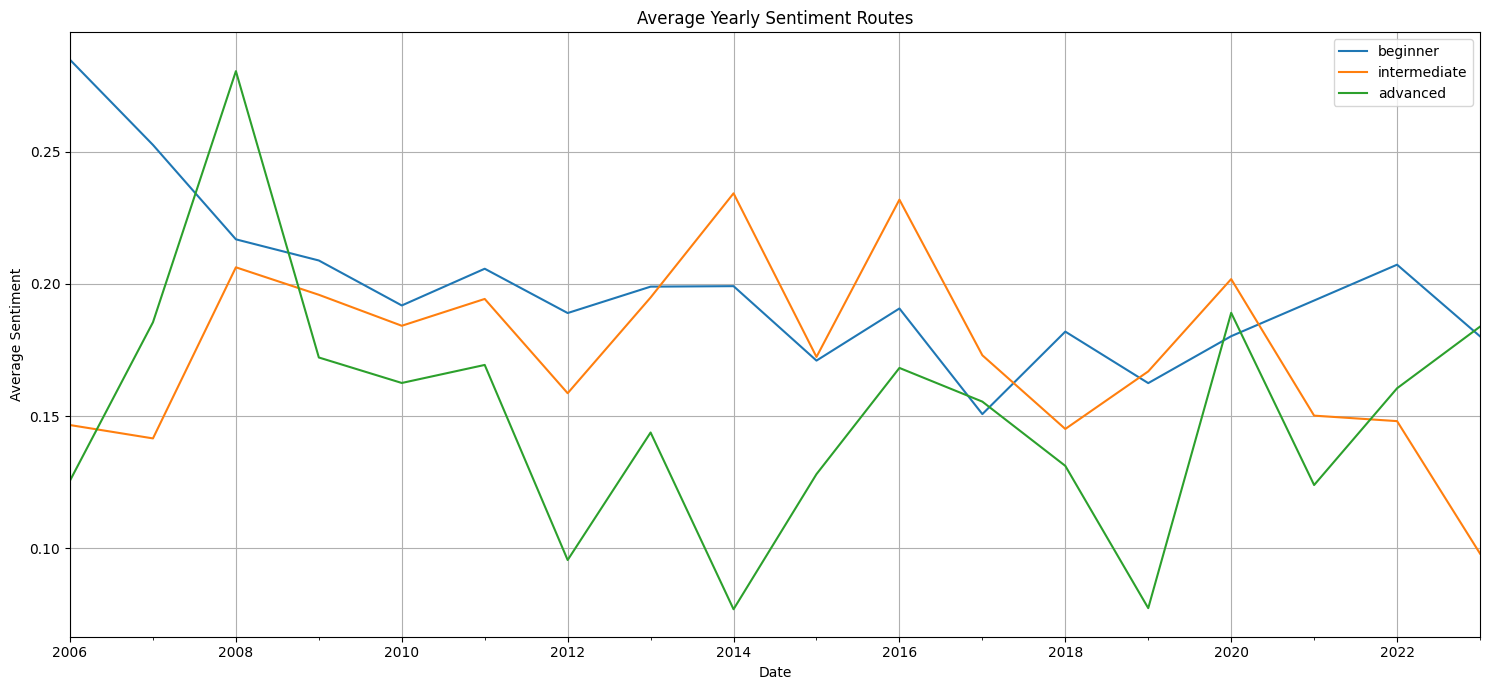

In [64]:
# Alternative approach: Grouping and resampling within each category separately

# Function to process and plot sentiment for a specific difficulty category
def plot_sentiment_for_difficulty(data, difficulty, ax):
    # Filter data for the specified difficulty
    difficulty_data = data[data['route_difficulty'] == difficulty]

    # Resample to get monthly average sentiment
    monthly_sentiment = difficulty_data.resample('Y', on='date')['sentiment'].mean()

    # Plotting
    monthly_sentiment.plot(ax=ax, label=difficulty)
    ax.set_title(f'Average Yearly Sentiment Routes')
    ax.set_xlabel('Date')
    ax.set_ylabel('Average Sentiment')
    ax.grid(True)
    ax.legend()

# Creating subplots
fig, axes = plt.subplots(1, 1, figsize=(15, 7))


# Plotting for each difficulty category
plot_sentiment_for_difficulty(df_comments, 'beginner', axes)
plot_sentiment_for_difficulty(df_comments, 'intermediate', axes)
plot_sentiment_for_difficulty(df_comments, 'advanced', axes)

plt.tight_layout()
plt.show()


### Seasonality


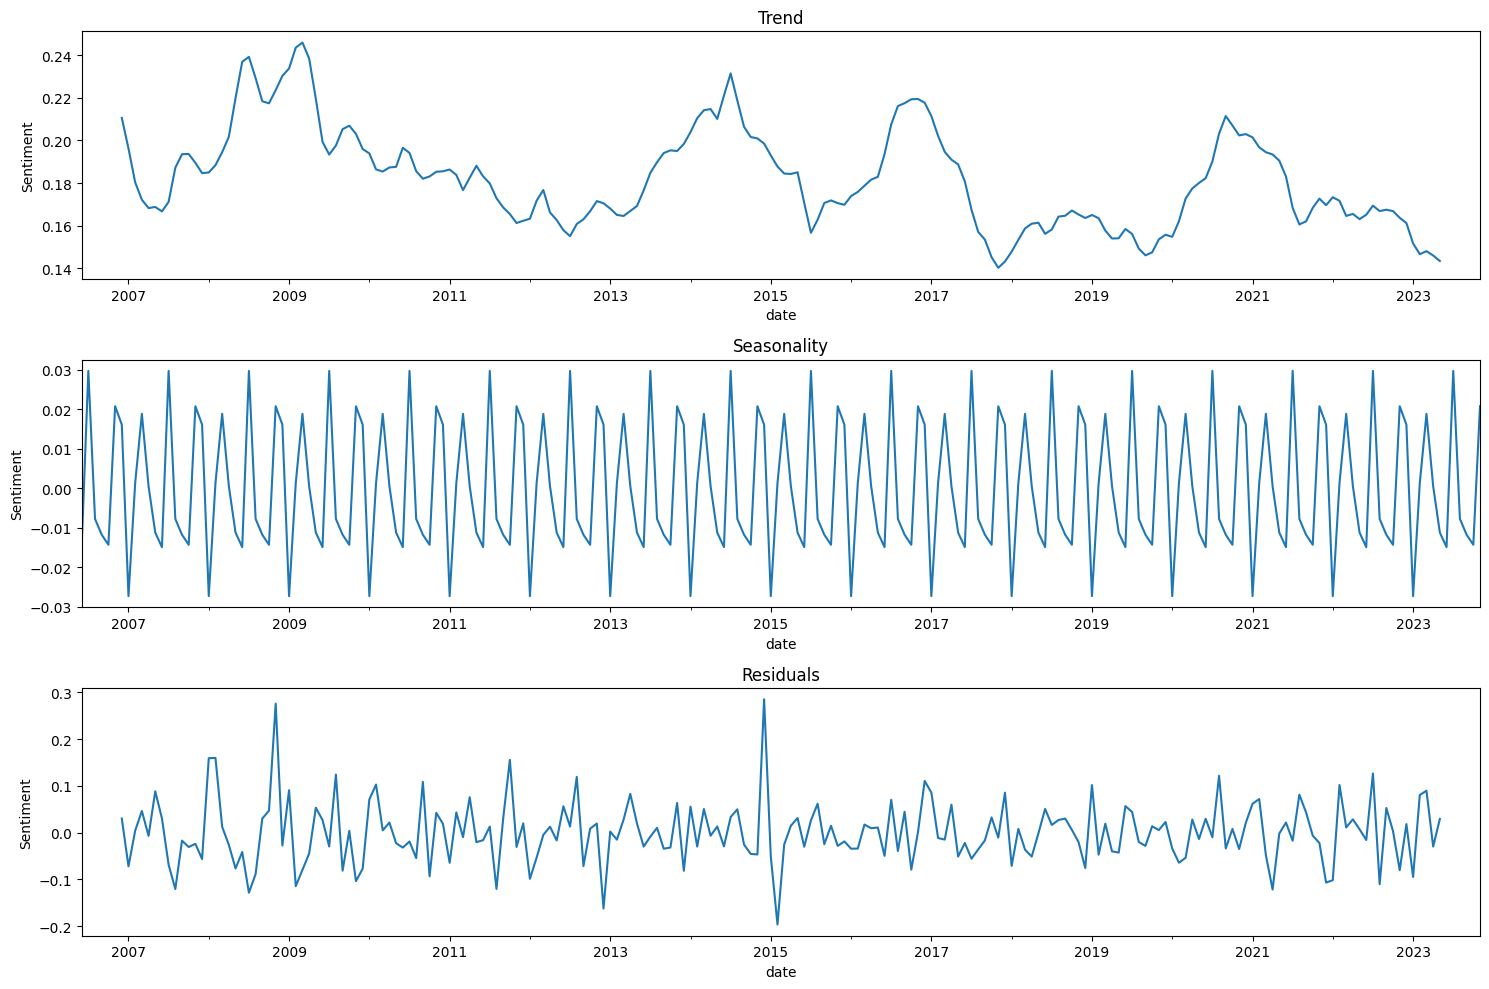

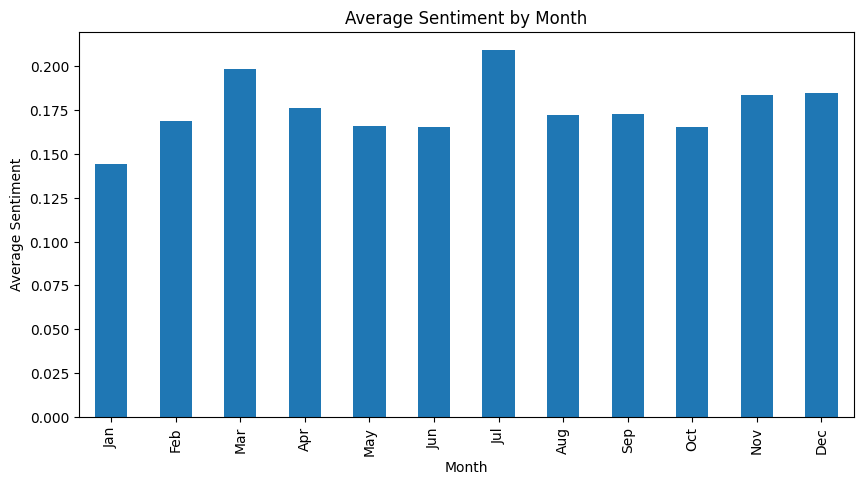

In [70]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Resampling the overall sentiment data monthly
overall_monthly_sentiment = df_comments.resample('M', on='date')['sentiment'].mean()

# Seasonal Decompose
decomposition = seasonal_decompose(overall_monthly_sentiment.dropna(), model='additive')

# Plotting the decomposed components
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10))

decomposition.trend.plot(ax=ax1)
ax1.set_title('Trend')
ax1.set_ylabel('Sentiment')

decomposition.seasonal.plot(ax=ax2)
ax2.set_title('Seasonality')
ax2.set_ylabel('Sentiment')

decomposition.resid.plot(ax=ax3)
ax3.set_title('Residuals')
ax3.set_ylabel('Sentiment')

plt.tight_layout()
plt.show()

# Preparing data for month-wise analysis
df_comments['month'] = df_comments['date'].dt.month
monthly_avg_sentiment = df_comments.groupby('month')['sentiment'].mean()

# Plotting month-wise average sentiment
plt.figure(figsize=(10, 5))
monthly_avg_sentiment.plot(kind='bar')
plt.title('Average Sentiment by Month')
plt.xlabel('Month')
plt.ylabel('Average Sentiment')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()


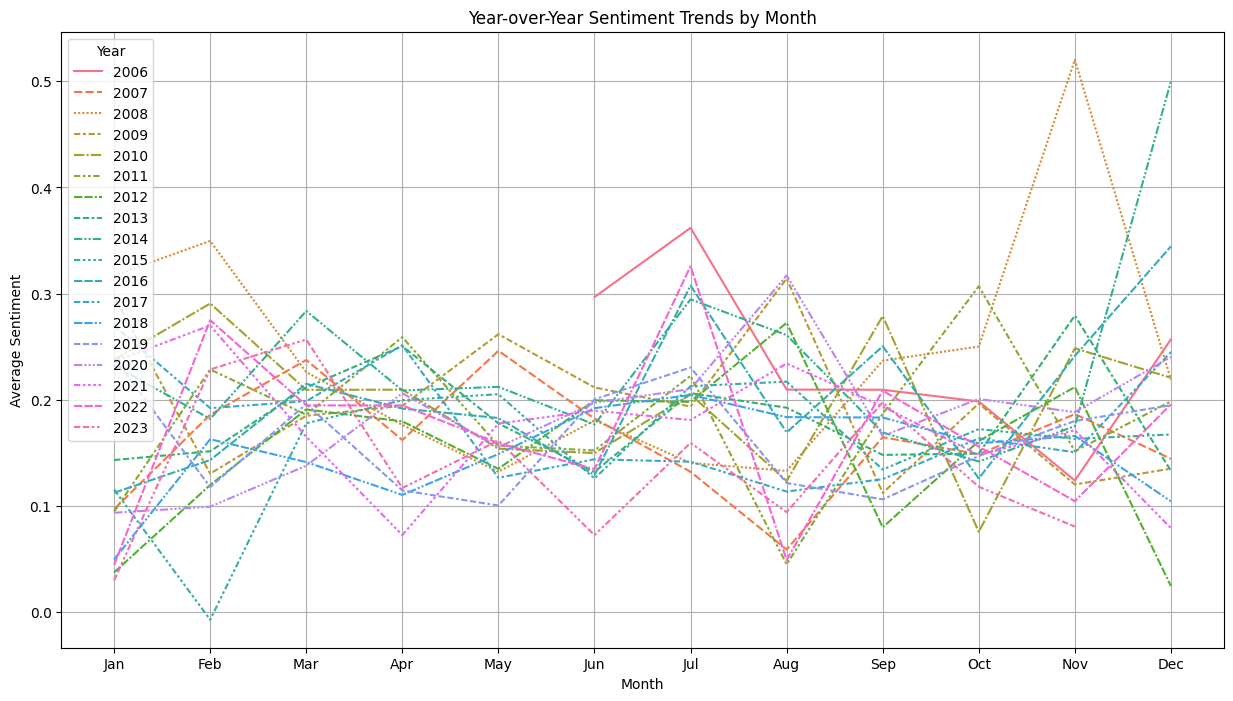

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# Re-load and prepare the dataset
file_path = 'data/comments/comments.csv'
comments_df = pd.read_csv(file_path)
comments_df['date'] = pd.to_datetime(comments_df['date'], errors='coerce')
comments_df['sentiment'] = comments_df['body'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Drop rows where date or sentiment could not be calculated
comments_df = comments_df.dropna(subset=['date', 'sentiment'])

# Extract year and month from the date
comments_df['year'] = comments_df['date'].dt.year
comments_df['month'] = comments_df['date'].dt.month

# Group by year and month
grouped_data = comments_df.groupby(['year', 'month'])['sentiment'].mean().unstack('year')

# Plotting year-over-year trends
plt.figure(figsize=(15, 8))
sns.lineplot(data=grouped_data)

plt.title('Year-over-Year Sentiment Trends by Month')
plt.xlabel('Month')
plt.ylabel('Average Sentiment')
plt.legend(title='Year', loc='upper left')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()


Text(0.5, 1.0, 'Year-over-year Variance of Sentiment by Month')

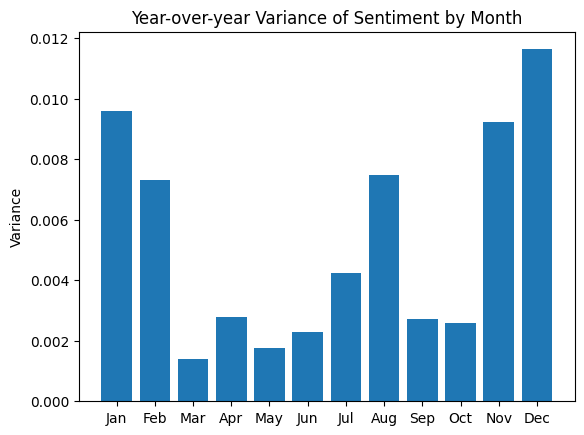

In [88]:
plt.bar(grouped_data.var(axis=1).index, grouped_data.var(axis=1))
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']);
plt.ylabel('Variance')
plt.title('Year-over-year Variance of Sentiment by Month')


### Topic Modeling

In [95]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim import corpora

# Download necessary NLTK data
# nltk.download('stopwords')
# nltk.download('wordnet')

# Preprocessing steps
stop = set(stopwords.words('english'))
stop.update(['climb', 'route', 'pitch', 'left', 'right', 'climbing', 'first', 'go', 'get'])
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    normalized = " ".join(lemma.lemmatize(word) for word in stop_free.split())
    return normalized

# Assuming comments_df is already loaded and has a 'body' column with comments
# Selecting a subset of comments for demonstration
subset_comments = comments_df['body'].sample(n=500, random_state=42).astype(str)

# Clean the documents
doc_clean = [clean(doc).split() for doc in subset_comments]

# Creating the term dictionary of our corpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(doc_clean)

# Converting list of documents (corpus) into Document Term Matrix using the dictionary prepared above
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

# Creating the object for LDA model
Lda = gensim.models.ldamodel.LdaModel

# Running and Training LDA model on the document term matrix with 5 topics
ldamodel = Lda(doc_term_matrix, num_topics=5, id2word = dictionary, passes=50)

# Output the top words in the topics
topics = ldamodel.print_topics(num_words=5)
topics


[(0,
  '0.009*"bolt" + 0.009*"top" + 0.009*"rap" + 0.007*"one" + 0.006*"anchor"'),
 (1,
  '0.006*"one" + 0.006*"rap" + 0.005*"great" + 0.005*"bolt" + 0.004*"like"'),
 (2,
  '0.005*"two" + 0.004*"last" + 0.004*"top" + 0.004*"like" + 0.004*"trail"'),
 (3,
  '0.007*"one" + 0.006*"like" + 0.006*"crack" + 0.005*"good" + 0.005*"move"'),
 (4,
  '0.005*"bolt" + 0.005*"pretty" + 0.004*"move" + 0.004*"crack" + 0.004*"one"')]